# A VarMiON for the heat equation with initial condition and Robin boundary condition

**SPDX-License-Identifier: GPL-3.0**  
**Copyright (c) 2025 NLALDlab**  
**Authors: NLALDlab, Marco Dell'Orto, Laura Rinaldi, Enrico Caregnato, Fabio Marcuzzi**

\begin{equation}
\left\{
\begin{aligned}
    C(\mathbf{x}) \partial_t u(t, \mathbf{x}) - \nabla_x \cdot (\theta(\mathbf{x}) \nabla_x u(t, \mathbf{x})) &= f(t, \mathbf{x}) \quad &&\forall (t,\mathbf{x}) \in (0,T) \times \Omega \\
    - \theta(\mathbf{x}) \frac{\partial u(t, \mathbf{x})}{\partial \mathbf{n}} &= h \, (u(t, \mathbf{x}) - g(t, \mathbf{x})) \quad &&\forall (t,\mathbf{x}) \in (0,T) \times \partial \Omega \\
    u(0, \mathbf{x}) &= u_0(\mathbf{x}) \quad &&\forall \mathbf{x} \in \Omega
\end{aligned}
\right.
\end{equation}

where
\begin{aligned}
     \Omega = [0,1]^2  \\
\end{aligned}

and $u$ is the temperature

In [1]:
import torch, math, os, sys, time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from scipy import stats
import seaborn as sns
from datetime import datetime
import pickle

from torch import nn
from torch.utils.data import random_split, DataLoader
import torch.optim as optim

os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
from abc import ABC, abstractmethod

from sympy.utilities.iterables import multiset_permutations
from itertools import product

In [2]:
# packages needed:
# numpy, torch, sympy
# for graphical content: matplotlib, scipy, seaborn

#python
import platform
print(f"python version = {platform.python_version()} \t (required: 3.11.10)")
# numpy
import numpy
print(f"{numpy.__version__ = } \t (required: 1.26.4)")
# torch
print(f"{torch.__version__ = } \t (required: 2.5.1)")
# sympy
import sympy
print(f"{sympy.__version__ = } \t (required: 1.13.1)")
# matplotlib
import matplotlib
print(f"{matplotlib.__version__ = } \t (required: 3.9.2)")
#scipy
import scipy
print(f"{scipy.__version__ = } \t (required: 1.14.1)")
# seaborn
import seaborn
print(f"{seaborn.__version__ = } \t (required: 0.13.2)")

python version = 3.11.10 	 (required: 3.11.10)
numpy.__version__ = '1.26.4' 	 (required: 1.26.4)
torch.__version__ = '2.5.1' 	 (required: 2.5.1)
sympy.__version__ = '1.13.1' 	 (required: 1.13.1)
matplotlib.__version__ = '3.9.2' 	 (required: 3.9.2)
scipy.__version__ = '1.14.1' 	 (required: 1.14.1)
seaborn.__version__ = '0.13.2' 	 (required: 0.13.2)


In [3]:
# GPU check
print(f"{torch.cuda.is_available() = }")
if torch.cuda.is_available():
    print(f"{torch.cuda.device_count() = }")
    print(f"{torch.cuda.current_device() = }")
    current_device = torch.cuda.current_device()
    print(f"{torch.cuda.device(current_device) = }")
    print(f"{torch.cuda.get_device_name(current_device) = }")
    print("\n")
#endif
    
## to check NVIDIA's CUDA compiler (nvcc) version
#!nvcc --version

torch.cuda.is_available() = True
torch.cuda.device_count() = 1
torch.cuda.current_device() = 0
torch.cuda.device(current_device) = <torch.cuda.device object at 0x7fd9f5741e10>
torch.cuda.get_device_name(current_device) = 'NVIDIA TITAN V'




# Error and Loss Function

In [4]:
class VarMiONLoss(torch.nn.Module):
    def __init__(self, n_grid_pts, times, J, tdim, goal_oriented = False):
        super().__init__()
        
        self.n_grid_pts = n_grid_pts
        self.J = J
        self.tdim = tdim
        self.goal_oriented = goal_oriented
                
        self.T = times[-1] - times[0]
        self.n_times = len(times)       
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        self.weights = self.quadrature_time(N=self.tdim+1, T=self.T, m=self.n_times-1, n=self.n_grid_pts-1)
        
    def quadrature_time(self, N, T, m, n):
        # Inputs:
        # N = space dimension of [0,T] x [0,1]^(N-1)
        # t = 0 initial time
        # T = final time
        # m = #subintervals in [0,T]
        # n = #subintervals in [0,1]
           
        def goal_function(): #goal: line y=0
            section_indices = []
            for i in range(n):
                section_indices.append([x for x in range(n*i,n*(i+1))])
            #endfor
            alpha = 1e6
            phi = np.ones((n+1)**self.tdim)
            for i,index in enumerate(section_indices):
                phi[index] = alpha**(1-i/n)
            #endfor
            phi = np.tile(phi, m)
            return phi
    
        def vertices(N): 
            return list(product((0, 1), repeat=N))
    
        def create_mesh(N, t_vec, x_vec):
            x_mesh = np.array(list(product(x_vec, repeat=N-1)))
            return [np.append(t,x) for t in t_vec for x in x_mesh]
        
        
        V = np.ones((N,N+1))
        V = np.tril(V)
    
        M = vertices(N)
        M = np.array(M).T
        x = np.zeros(2**N)
    
        for sigma in multiset_permutations(np.arange(N)):
            V_sigma = V.copy()
            V_sigma = V[sigma,:]
            for i in range(N+1):
                tmp = np.all(V_sigma[:,i] == M.T, axis = 1)
                j = np.where(tmp)[0][0]
                x[j] += 1
            #endfor
        #endfor
    
        t_vec = np.arange(0,m+1)
        x_vec = np.arange(0,n+1)
        points = np.array(create_mesh(N, t_vec, x_vec)).T
    
        num_points = (m+1)*((n+1)**(N-1))
        y = np.zeros(num_points)


        for i in range(m):
            for valori in product(np.arange(0,n), repeat=N-1):
                M_tmp = M.copy()
                M_tmp[0,:] += i
                for j in range(1,N):
                    M_tmp[j,:] += valori[j-1]
                #endfor
                
                for k in range(2**N):
                    tmp = np.all(M_tmp[:,k] == points.T, axis = 1)
                    indice_vertice = np.where(tmp)[0][0]
                    y[indice_vertice] += x[k]
                #endfor
            #endfor
        #endfor
        
        num_simplessi = math.factorial(N) * m * n**(N-1)
        c = T / ((N+1) * num_simplessi)

        # weights w
        w = c*y
        
        w = w[(n+1)**(N-1):]
        
        if self.goal_oriented == True:
            phi = goal_function()
            g_o_w = w*phi #goal oriented weights
            w = g_o_w/sum(g_o_w)*sum(w) #weights are normalized

        return w

    def forward(self, input, target):
        
        W = torch.tile(self.weights, (self.J,)).to(self.device)

        diff = target - input    
        return torch.sum(W * diff.view(-1)**2)/self.J         
   

# Customized Dataset Class

In [5]:
class dataset_heat_eq_robin(torch.utils.data.Dataset):
    def __init__(self, dataset_settings_dict):
        super().__init__()
                        
        self.num_pdes = dataset_settings_dict['num_pdes'] # integer equal to the number of instances of the pde to be considered
        data_dir = dataset_settings_dict['data_dir'] # path of the directory containing the dataset
        
        
        with open(data_dir + '/eval_pts', 'rb') as file:
            self.param_pts = np.load(file) # coords of the points used to sample the parameters
            self.param_bry_pts = np.load(file) # coords of the points used to sample the parameters defined on the boundary
            self.temp_pts = np.load(file) # coords of the points used to sample the temperature
            self.times = np.load(file) # array of the times considered in the dataset (includes t=0)
        
        self.n_param_pts = self.param_pts.shape[0]
        self.n_param_bry_pts = self.param_bry_pts.shape[0]
        self.n_temp_pts = self.temp_pts.shape[0]
        self.n_times = len(self.times)
        
        self.tdim = self.temp_pts.shape[1]
             
        self.data = dict(
            f = np.zeros(shape = (self.num_pdes, self.n_times-1, self.n_param_pts), dtype = np.float32),
            theta = np.zeros(shape = (self.num_pdes, self.n_param_pts), dtype = np.float32),
            c = np.zeros(shape = (self.num_pdes, self.n_param_pts), dtype = np.float32),
            g = np.zeros(shape = (self.num_pdes, self.n_times-1, self.n_param_bry_pts), dtype = np.float32),
            h = np.zeros(shape = (self.num_pdes), dtype = np.float32),
            u0 = np.zeros(shape = (self.num_pdes, self.n_times-1, self.n_temp_pts), dtype = np.float32),
            solution = np.zeros(shape = (self.num_pdes, self.n_times-1, self.n_temp_pts), dtype = np.float32),
        )
        
        self.dir_record = lambda t: f"{data_dir}/record_{t}.npy"
       
        self.check_files_exist()
                   
        for i in range(self.num_pdes):
            self.load_data(i)
        #endfor
                
        self.data = {k: torch.tensor(v, device='cpu', dtype=torch.float32) for k, v in self.data.items()}
        self.temp_pts = torch.tensor(self.temp_pts, device='cpu', dtype=torch.float32)
        self.times = torch.tensor(self.times, device='cpu', dtype=torch.float32)
        
        times_tensor = self.times[1:].view(self.n_times-1, 1, 1).expand(-1, self.n_temp_pts, 1) # size: (n_times-1,n_eval,1)
        points_tensor = self.temp_pts.unsqueeze(0).expand(self.n_times-1, -1, -1) # size: (n_times-1, n_eval, d)        
        self.nodes_tx = torch.cat((times_tensor, points_tensor), dim=-1) # size: (n_times-1, n_eval, 1+d)               
        print("Dataset loaded")
                       
    def __len__(self):
        return self.num_pdes
  
    def load_data(self, i: int) -> None:
        with open(self.dir_record(i), 'rb') as file:
                    
            self.data["c"][i,:] = np.load(file)
            self.data["theta"][i,:] = np.load(file)
            self.data["f"][i,:,:] = np.load(file)
            self.data["h"][i] = np.load(file)
            self.data["g"][i,:,:] = np.load(file)
            tmp = np.load(file) # solution
        
        self.data["u0"][i,:] = tmp[:-1,:]
        self.data["solution"][i,:,:] = tmp[1:,:]
        
    def check_files_exist(self) -> bool:
        for i in range(self.num_pdes):
            if not os.path.exists(self.dir_record(i)):
                print(f"check {i}: False", )
                return False
        print("Dataset files found...")
        return True

    def __getitem__(self, idx):
        
        input_tx = self.nodes_tx
        input_c = self.data['c'][idx, :] 
        input_theta = self.data['theta'][idx, :]      
        input_f = self.data['f'][idx, :, :]
        input_h = self.data['h'][idx]
        input_g = self.data['g'][idx, :, :]
        input_u0 = self.data['u0'][idx,:,:]
        output = self.data['solution'][idx, :, :]

        
        #print("__getitem__")
        #print(f"{input_tx.size() = }")
        #print(f"{input_c.size() = }")
        #print(f"{input_theta.size() = }")
        #print(f"{input_f.size() = }")
        #print(f"{input_h.size() = }")
        #print(f"{input_g.size() = }")
        #print(f"{input_u0.size() = }")
        #print(f"{output.size() = }")
        
        return input_tx, input_c, input_theta, input_f, input_h, input_g, input_u0, output

# Neural Network Model

<img src="network_architecture.png" alt="Image not found" width="800" height="200"/>

In [6]:
class HeatEquationVarMiONRobin(nn.Module):
    def __init__(self):
        super().__init__()
            
        self.c_branch = nn.Sequential(
            nn.Linear(in_features=100, out_features=100, bias = False),          
        )       
        
        self.theta_branch = nn.Sequential(
            nn.Linear(in_features=100, out_features=100, bias = False),          
        )

        self.h_branch = nn.Sequential(
            nn.Linear(in_features=100, out_features=100, bias = False),         
        )
                     
        self.f_branch = nn.Sequential(
            nn.Linear(in_features=100, out_features=64, bias = False)
        )
        
        self.gh_branch = nn.Sequential(
            nn.Linear(in_features=36, out_features=64, bias = False)
        )
        
        
        self.u0_branch = nn.Sequential(
            nn.Linear(in_features=100, out_features=64, bias = False)         
        )    
        

        self.inversion_net = nn.Sequential(
            nn.Unflatten(1, (1, 10, 10)), 
            nn.ConvTranspose2d(in_channels=1, out_channels=8, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(in_channels=8, out_channels=16, kernel_size=4, stride=1),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(in_channels=16,out_channels= 8, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.ConvTranspose2d(in_channels=8, out_channels=1, kernel_size=2, stride=2),
            nn.ReLU(),
            nn.Flatten(),
            nn.Unflatten(1,(64,64))
        )

        self.trunk_branch = nn.Sequential(
            nn.Linear(in_features=3, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=100),
            nn.ReLU(),
            nn.Linear(in_features=100, out_features=64)
        )

    def forward(self, inputs):
        input_tx, input_c, input_theta, input_f, input_h, input_g, input_u0 = inputs
        
        #print("nn forward")
        #print("input_tx", input_tx.size())
        #print("input_c", input_c.size())
        #print("input_theta", input_theta.size())
        #print("input_f", input_f.size())
        #print("input_h", input_h.size())
        #print("input_g", input_g.size())
        #print("input_u0", input_u0.size())
        
        c_branch = self.c_branch(input_c)
        #print("c_branch ", c_branch.size())
        
        theta_branch = self.theta_branch(input_theta)
        #print("theta_branch ", theta_branch.size())
              
        h_branch = self.h_branch(input_h.view(-1,1).expand(-1, 100))
        #print(f"{h_branch.size() = }")
        
        sum_branch = c_branch + theta_branch + h_branch
        #print(f"{sum_branch.size() = }")
        
        inversion_net = self.inversion_net(sum_branch)
        #print(f"{inversion_net.size() = }")
        
        f_branch = self.f_branch(input_f)
        #print(f"{f_branch.size() = }")
                
        gh_branch = input_h.view(-1,1,1) * self.gh_branch(input_g)
        #print(f"{gh_branch.size() = }")
        
        u0_branch = self.u0_branch(input_u0)
        #print(f"{u0_branch.size() = }")
        
        sum_rhs = f_branch + gh_branch + u0_branch
        #print(f"{sum_rhs.size() = }")
        
        trunk = self.trunk_branch(input_tx)
        #print(f"{trunk.size() = }")
        
        sum_rhs = sum_rhs.unsqueeze(-1)
        #print(f"unsqueeze {sum_rhs.size() = }")
        
        inversion_net = inversion_net.unsqueeze(1)
        #print(f"unsqueeze {inversion_net.size() = }")
        
        output = torch.matmul(inversion_net, sum_rhs)
        #print(f"coeff {output.size() = }")
        
        output = output.unsqueeze(2)
        #print(f"unsqueeze {output.size() = }")
        
        trunk = trunk.unsqueeze(3)
        #print(f"unsqueeze {trunk.size() = }")
        
        output = torch.matmul(trunk, output)
        #print(f"basis {output.size() = }")
        
        output = output.squeeze(-1).squeeze(-1)
        #print(f"squeeze {output.size() = }") 

        return output

# VarMiON Class for training/validation/testing of a Variationally Mimetic Operator Network

In [7]:
class VarMiON():
    def __init__(self, dataset, training_parameters_dict):
        
        self.training_parameters_dict = training_parameters_dict
        self.save_dir = training_parameters_dict["save_dir"]
        self.dataset = dataset
        self.tdim = dataset.tdim        
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'        
        print(f"Device = {self.device}")       
        
        self.n_grid_pts = int(np.sqrt(self.dataset.n_temp_pts))
        
        self.loss_err = VarMiONLoss(n_grid_pts = self.n_grid_pts, times=self.dataset.times, J=1, tdim=self.tdim)
           
        self.epoch = 0
           
        # compute the size of the dataset and of the training, validation and testing sub-datasets
        train_fraction = 0.8
        val_fraction = 0.1
        test_fraction = 0.1
        
        n_total = len(self.dataset)
        n_train = int(n_total*train_fraction)
        n_val = int(n_total*val_fraction)
        n_test = int(n_total*test_fraction)      
        
        print(f"Number of PDE instances in the dataset: {n_total}") 
        print(f"Used for the training: {n_train}")
        print(f"Used for the validation: {n_val}")
        print(f"Used for the testing: {n_test}") 
                
        generator = torch.Generator().manual_seed(self.training_parameters_dict['seed'])
        self.train_data, self.val_data, self.test_data = random_split(self.dataset, [train_fraction,val_fraction,test_fraction], generator=generator)
            
        # these tensors will contain the value of the loss function at each epoch
        self.losses = ...
        self.val_losses = ...   
        
        self.best_epoch = 0       
        self.test_error_best = torch.zeros(n_test).to(self.device) # contains relative error
        self.test_abs_error_best = torch.zeros(n_test).to(self.device) # contains absolute error     
    

    def train_step_fn(self, X, y):
        self.model.train()
                
        pred = self.model(X)        
        loss = self.loss_fn(pred, y)
        
        loss.backward()
        self.optimizer.step()
        self.optimizer.zero_grad()
        
        return loss.item()
        

    def val_step_fn(self, X, y):
        self.model.eval()
        
        pred = self.model(X)                   
        loss = self.loss_fn(pred, y)
          
        return loss.item()

       
    def test_step_fn(self, X, y):
        self.model.eval()
        
        pred = self.model(X)                   
        loss = self.test_loss_fn(pred, y)
        
        
        # compute error
        y_quad = self.loss_err(y, torch.zeros(y.shape).to(self.device))
        diff_quad = self.loss_err(pred, y)
        
        self.test_error_best[self.counter_test] = torch.sqrt(diff_quad/y_quad)
        self.test_abs_error_best[self.counter_test] = torch.sqrt(diff_quad)
        
        self.counter_test += 1
                
        return loss.item()

    def _mini_batch(self, mode):
        if mode=="validation":
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        elif mode=="training":
            data_loader = self.train_loader
            step_fn = self.train_step_fn
        elif mode=="testing":
            data_loader = self.test_loader
            step_fn = self.test_step_fn
        #endif

        mini_batch_losses = []
        
        
        for j, my_data in enumerate(data_loader):
    
            #print("__minibatch__")
            #for i, x in enumerate(my_data):
            #    print(f"input {i}: \t {x.size()}")
            ##endfor
            #print()
                
            X = [elem.to(self.device) for elem in my_data[:-1]]
            y = my_data[-1].to(self.device)    
            
            mini_batch_loss = step_fn(X,y)
            mini_batch_losses.append(mini_batch_loss)
        #endfor
                                     
        loss = np.mean(mini_batch_losses)
        return loss
    
    
    def _train(self, n_epochs, seed=1):
        for epoch in range(n_epochs):
            print(f"Epoch {epoch+1}/{n_epochs}")
            
            start_epoch = time.time()            
            self.epoch = epoch
            
            # training
            loss = self._mini_batch(mode="training")
            self.losses[epoch] = loss                                   

            with torch.no_grad():                
                # validation
                val_loss = self._mini_batch(mode="validation")
                self.val_losses[epoch] = val_loss
                
                if val_loss < self.val_loss_min:
                    self.best_epoch = epoch
                    self.val_loss_min = val_loss
                    torch.save(self.model.state_dict(), self.save_dir + '/model_weights_best.pth')
                #endif
                                              
            if self.verbose:
                print(f"{'Loss':<15}= {val_loss:.14f}")
                print(f"{'Lowest loss':<15}= {self.val_loss_min:.14f} at epoch {self.best_epoch+1}")
                print(f"Elapsed time = {(time.time() - start_epoch):.2f} s")
                print()                
            #endif
            
                      
    def training_validation(self, verbose=False):
        
        start_timer = time.time()
                        
        n_epochs = self.training_parameters_dict['n_epochs']
        self.pdes_per_batch = self.training_parameters_dict['pdes_per_batch']
        self.verbose = verbose
              
        self.train_loader = DataLoader(self.train_data, batch_size=self.pdes_per_batch, shuffle=True)
        self.val_loader = DataLoader(self.val_data, batch_size=self.pdes_per_batch)
        
               
        # these tensors will contain the value of the loss function at each epoch
        self.losses = torch.zeros(n_epochs).to(self.device)
        self.val_losses = torch.zeros(n_epochs).to(self.device)
        self.val_loss_min = float('inf')                   
                      
        self.loss_fn = VarMiONLoss(n_grid_pts = self.n_grid_pts, times=self.dataset.times, J=self.pdes_per_batch, tdim = self.tdim, goal_oriented = self.training_parameters_dict['goal_oriented'])
                     
        # create the model and send it to device
        self.model = HeatEquationVarMiONRobin()
        self.model.to(self.device)
                
        # compute total number of parameters
        total_params = sum(p.numel() for p in self.model.parameters() if p.requires_grad)
        print("Number of parameters of the NN: ", total_params, "\n")
        
        # define the optimizer
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.training_parameters_dict['lr']) 

        # training
        self._train(n_epochs)
                        
        self.losses = self.losses.detach().cpu().numpy()
        self.val_losses = self.val_losses.detach().cpu().numpy()
                
        print(f"\n Total elapsed time: {(time.time() - start_timer):.2f} s")
        
        
        
        
        
    def plot_losses(self, save_dir = None):
                                     
        #fig, ax = plt.subplots()
        #ax.plot(varmion.losses, '-r', label='Training')
        #ax.plot(varmion.val_losses, '-b', label='Validation')
        #ax.set_title("Training and Validation Loss")
        #ax.set_xlabel("Epoch")
        #ax.set_ylabel("Loss")
        #ax.legend()
        #ax.grid()
        
        fig, ax = plt.subplots(1,2, figsize=(16,8))
        ax[0].plot(varmion.losses, '-r', label='Training')
        ax[0].plot(varmion.val_losses, '-b', label='Validation')
        ax[0].set_title("Training and Validation Loss")
        ax[0].set_xlabel("Epoch")
        ax[0].set_ylabel("Loss")
        ax[0].legend()
        ax[0].grid()
                      
        ax[1].semilogy(varmion.losses, '-r', label='Training')
        ax[1].semilogy(varmion.val_losses, '-b', label='Validation')
        ax[1].set_title("Training and Validation Loss")
        ax[1].set_xlabel("Epoch")
        ax[1].set_ylabel("Loss")
        ax[1].legend()
        ax[1].grid()

                      

        if save_dir is not None:
            fig.savefig(save_dir + '/losses.png', bbox_inches='tight')
            np.save(save_dir + '/training_losses', self.losses)
            np.save(save_dir + '/val_losses', self.val_losses)
        
              
    def testing(self, plots = True, save_dir = None):
            
        # create the model and send it to device
        self.model = HeatEquationVarMiONRobin()
        self.model.to(self.device)
        
        # load the best model's weights
        self.model.load_state_dict(torch.load(self.save_dir + '/model_weights_best.pth', weights_only=True))
        self.model.eval()
                
        self.test_loader = DataLoader(self.test_data, batch_size=1)
        self.test_loss_fn = VarMiONLoss(n_grid_pts = self.n_grid_pts, times=self.dataset.times, J=1, tdim = self.tdim, goal_oriented = self.training_parameters_dict['goal_oriented'])
       
        with torch.no_grad():
            
            self.counter_test = 0
            self.test_loss_best = self._mini_batch(mode="testing") # it computes self.test_error_best too
            
        self.test_error_best_numpy = self.test_error_best.detach().cpu().numpy()
        self.test_abs_error_best_numpy = self.test_abs_error_best.detach().cpu().numpy()
        
        
        if plots:
            err_rel = self.test_error_best_numpy*100
            print("Relative error on the test dataset")                  
            print(f"Mean: {np.mean(self.test_error_best_numpy)*100:.2f} %")
            print(f"std:  {np.std(self.test_error_best_numpy)*100:.2f} %")
            print()
                
            density = stats.gaussian_kde(err_rel)
            x = np.linspace(min(err_rel), max(err_rel), 100)
                            
            fig1, ax1 = plt.subplots()
            ax1.plot(x, density(x), color='C0')
            ax1.hist(err_rel, bins=15, density=True, color='C0', alpha=0.8)
            ax1.set_title(r'Probability density of the relative $L_2$ error - testing dataset')
            ax1.set_xlabel(r'% Relative $L_2$ error')
            ax1.set_ylabel('Density')
            ax1.set_xlim(0., max(err_rel)+0.1)
            ax1.grid()
            
            if save_dir is not None:
                fig1.savefig(save_dir + "/density_relative_error.png", bbox_inches='tight')
            
            fig2, ax2 = plt.subplots(figsize=(14, 1))  
            
            rug = sns.rugplot(err_rel, height=1, color='C0', label='varmion', ax=ax2)
            rug.set_xlim(0., max(err_rel)+0.1)
            rug.set(yticklabels=[])

            ax2.set_xlabel(r'% Relative $L_2$ error')
            ax2.set_title(r'Distribution of the relative $L_2$ error - testing dataset')
        
            if save_dir is not None:
                fig2.savefig(save_dir + "/distribution_relative_error.png", bbox_inches='tight')

    

# User settings

In [8]:
num_pdes = 2000         # number of PDE instances in the dataset
n_epochs = 1000          # number of training epochs
pdes_per_batch = 8      # number of PDE instances in each batch
lr = 1e-4               # learning rate
goal_oriented = False   # if True, use a goal-oriented loss function
seed = 42               # Initialize random seed 

my_dataset_path = "/home/marcodellorto/datasets"   # directory containing the dataset folder
my_results_path = "/home/marcodellorto/VarMiON_phd/VarMiON_NLALD/RESULTS" # directory in which to save the results folder

# Training/validation/testing

In [9]:
# set torch seed
torch.manual_seed(seed);

# Uncomment the following lines to ensure full reproducibility by enabling deterministic behavior 
# in low-level CUDA/cuBLAS matrix operations
# note: may impact performance

#torch.backends.cudnn.deterministic = True
#torch.backends.cudnn.benchmark = False
#os.environ["CUBLAS_WORKSPACE_CONFIG"] = ":4096:8"


## Preparation of the experiment

In [10]:
# create a directory that will contain the results from the experiment
name_dir = "results_2d_robin_" + datetime.now().strftime("%Y%m%d_%H%M") # name of results folder
save_dir = f"{my_results_path}/{name_dir}" # where to save results dir
os.system(f'mkdir {save_dir}')


# Dictionary to store dataset settings:
dataset_settings_dict = {}
dataset_settings_dict['num_pdes'] = num_pdes 
data_dir = f"{my_dataset_path}/heat_eq_robin_2d_{dataset_settings_dict['num_pdes']}" # path of the directory containing the dataset
dataset_settings_dict['data_dir'] = data_dir

with open(save_dir + "/dataset_settings_dict", "wb") as handle:
    pickle.dump(dataset_settings_dict, handle)

# Dictionary to store training parameters:
training_parameters_dict = {}
training_parameters_dict['n_epochs'] = n_epochs
training_parameters_dict['pdes_per_batch'] = pdes_per_batch
training_parameters_dict['lr'] = lr
training_parameters_dict['goal_oriented'] = goal_oriented 
training_parameters_dict['save_dir'] = save_dir
training_parameters_dict['seed'] = seed

with open(save_dir + "/training_parameters_dict", "wb") as handle:
    pickle.dump(training_parameters_dict, handle)

# Dictionary to store main experiment details and results
result_dict = {}
result_dict['num_pdes'] = num_pdes
result_dict['n_epochs'] = n_epochs
result_dict['pdes_per_batch'] = pdes_per_batch
result_dict['goal_oriented'] = goal_oriented
result_dict['description'] = "Robin; 2d"

In [11]:
# Generate a new dataset if none exists (requires DOLFINx to be installed in your Python environment)
if os.path.isdir(data_dir):
    print("Dataset directory exists")
else:
    %run data_generation_heat_eq_robin_2d_fenicsx.py --num_pdes num_pdes
#endif

Dataset directory exists


In [12]:
# create dataset object
dataset = dataset_heat_eq_robin(dataset_settings_dict)


Dataset files found...
Dataset loaded


In [13]:
# create varmion object
varmion = VarMiON(dataset, training_parameters_dict)  

Device = cuda
Number of PDE instances in the dataset: 2000
Used for the training: 1600
Used for the validation: 200
Used for the testing: 200


## Training and validation

Number of parameters of the NN:  85085 

Epoch 1/1000
Loss           = 0.00409220698364
Lowest loss    = 0.00409220698364 at epoch 1
Elapsed time = 5.45 s

Epoch 2/1000
Loss           = 0.00230672447891
Lowest loss    = 0.00230672447891 at epoch 2
Elapsed time = 3.18 s

Epoch 3/1000
Loss           = 0.00154600932218
Lowest loss    = 0.00154600932218 at epoch 3
Elapsed time = 2.99 s

Epoch 4/1000
Loss           = 0.00121466837617
Lowest loss    = 0.00121466837617 at epoch 4
Elapsed time = 3.81 s

Epoch 5/1000
Loss           = 0.00096940419690
Lowest loss    = 0.00096940419690 at epoch 5
Elapsed time = 4.16 s

Epoch 6/1000
Loss           = 0.00086121311255
Lowest loss    = 0.00086121311255 at epoch 6
Elapsed time = 4.15 s

Epoch 7/1000
Loss           = 0.00078723826215
Lowest loss    = 0.00078723826215 at epoch 7
Elapsed time = 4.09 s

Epoch 8/1000
Loss           = 0.00073041439545
Lowest loss    = 0.00073041439545 at epoch 8
Elapsed time = 3.37 s

Epoch 9/1000
Loss           = 0.0006941

Loss           = 0.00006600499721
Lowest loss    = 0.00006484215989 at epoch 96
Elapsed time = 4.14 s

Epoch 99/1000
Loss           = 0.00006114960522
Lowest loss    = 0.00006114960522 at epoch 99
Elapsed time = 4.18 s

Epoch 100/1000
Loss           = 0.00006406629674
Lowest loss    = 0.00006114960522 at epoch 99
Elapsed time = 4.16 s

Epoch 101/1000
Loss           = 0.00006080385062
Lowest loss    = 0.00006080385062 at epoch 101
Elapsed time = 4.17 s

Epoch 102/1000
Loss           = 0.00006376172071
Lowest loss    = 0.00006080385062 at epoch 101
Elapsed time = 4.16 s

Epoch 103/1000
Loss           = 0.00006216022112
Lowest loss    = 0.00006080385062 at epoch 101
Elapsed time = 4.16 s

Epoch 104/1000
Loss           = 0.00006312360040
Lowest loss    = 0.00006080385062 at epoch 101
Elapsed time = 4.14 s

Epoch 105/1000
Loss           = 0.00006650797187
Lowest loss    = 0.00006080385062 at epoch 101
Elapsed time = 4.16 s

Epoch 106/1000
Loss           = 0.00005819375261
Lowest loss    = 0

Loss           = 0.00004345426159
Lowest loss    = 0.00004345426159 at epoch 167
Elapsed time = 4.19 s

Epoch 168/1000
Loss           = 0.00004531650903
Lowest loss    = 0.00004345426159 at epoch 167
Elapsed time = 4.19 s

Epoch 169/1000
Loss           = 0.00004484876360
Lowest loss    = 0.00004345426159 at epoch 167
Elapsed time = 4.18 s

Epoch 170/1000
Loss           = 0.00004731110400
Lowest loss    = 0.00004345426159 at epoch 167
Elapsed time = 3.59 s

Epoch 171/1000
Loss           = 0.00004647516781
Lowest loss    = 0.00004345426159 at epoch 167
Elapsed time = 4.16 s

Epoch 172/1000
Loss           = 0.00004309179524
Lowest loss    = 0.00004309179524 at epoch 172
Elapsed time = 4.14 s

Epoch 173/1000
Loss           = 0.00004445714303
Lowest loss    = 0.00004309179524 at epoch 172
Elapsed time = 4.17 s

Epoch 174/1000
Loss           = 0.00005297077980
Lowest loss    = 0.00004309179524 at epoch 172
Elapsed time = 4.17 s

Epoch 175/1000
Loss           = 0.00004224920749
Lowest loss   

Loss           = 0.00004145574929
Lowest loss    = 0.00003396758122 at epoch 270
Elapsed time = 4.04 s

Epoch 279/1000
Loss           = 0.00004271558928
Lowest loss    = 0.00003396758122 at epoch 270
Elapsed time = 4.04 s

Epoch 280/1000
Loss           = 0.00003374083287
Lowest loss    = 0.00003374083287 at epoch 280
Elapsed time = 4.08 s

Epoch 281/1000
Loss           = 0.00003435439834
Lowest loss    = 0.00003374083287 at epoch 280
Elapsed time = 4.06 s

Epoch 282/1000
Loss           = 0.00003481206581
Lowest loss    = 0.00003374083287 at epoch 280
Elapsed time = 4.04 s

Epoch 283/1000
Loss           = 0.00003515849055
Lowest loss    = 0.00003374083287 at epoch 280
Elapsed time = 4.05 s

Epoch 284/1000
Loss           = 0.00003375508296
Lowest loss    = 0.00003374083287 at epoch 280
Elapsed time = 4.07 s

Epoch 285/1000
Loss           = 0.00003499145095
Lowest loss    = 0.00003374083287 at epoch 280
Elapsed time = 3.88 s

Epoch 286/1000
Loss           = 0.00003462646931
Lowest loss   

Loss           = 0.00003206253714
Lowest loss    = 0.00003090639988 at epoch 345
Elapsed time = 4.12 s

Epoch 348/1000
Loss           = 0.00003126862837
Lowest loss    = 0.00003090639988 at epoch 345
Elapsed time = 4.10 s

Epoch 349/1000
Loss           = 0.00003397755324
Lowest loss    = 0.00003090639988 at epoch 345
Elapsed time = 4.11 s

Epoch 350/1000
Loss           = 0.00003170330965
Lowest loss    = 0.00003090639988 at epoch 345
Elapsed time = 4.12 s

Epoch 351/1000
Loss           = 0.00003368093929
Lowest loss    = 0.00003090639988 at epoch 345
Elapsed time = 4.12 s

Epoch 352/1000
Loss           = 0.00003358137788
Lowest loss    = 0.00003090639988 at epoch 345
Elapsed time = 4.11 s

Epoch 353/1000
Loss           = 0.00003072605131
Lowest loss    = 0.00003072605131 at epoch 353
Elapsed time = 4.05 s

Epoch 354/1000
Loss           = 0.00003109674527
Lowest loss    = 0.00003072605131 at epoch 353
Elapsed time = 4.12 s

Epoch 355/1000
Loss           = 0.00003149299064
Lowest loss   

Loss           = 0.00003009037040
Lowest loss    = 0.00002879142305 at epoch 414
Elapsed time = 4.04 s

Epoch 417/1000
Loss           = 0.00003009069024
Lowest loss    = 0.00002879142305 at epoch 414
Elapsed time = 4.11 s

Epoch 418/1000
Loss           = 0.00002868646149
Lowest loss    = 0.00002868646149 at epoch 418
Elapsed time = 4.12 s

Epoch 419/1000
Loss           = 0.00002861972588
Lowest loss    = 0.00002861972588 at epoch 419
Elapsed time = 4.13 s

Epoch 420/1000
Loss           = 0.00003050092384
Lowest loss    = 0.00002861972588 at epoch 419
Elapsed time = 4.11 s

Epoch 421/1000
Loss           = 0.00003080754542
Lowest loss    = 0.00002861972588 at epoch 419
Elapsed time = 4.12 s

Epoch 422/1000
Loss           = 0.00002834093652
Lowest loss    = 0.00002834093652 at epoch 422
Elapsed time = 4.11 s

Epoch 423/1000
Loss           = 0.00003204473124
Lowest loss    = 0.00002834093652 at epoch 422
Elapsed time = 4.12 s

Epoch 424/1000
Loss           = 0.00002860608753
Lowest loss   

Loss           = 0.00002771220993
Lowest loss    = 0.00002684370700 at epoch 462
Elapsed time = 4.11 s

Epoch 486/1000
Loss           = 0.00002681148294
Lowest loss    = 0.00002681148294 at epoch 486
Elapsed time = 4.12 s

Epoch 487/1000
Loss           = 0.00002740195458
Lowest loss    = 0.00002681148294 at epoch 486
Elapsed time = 4.12 s

Epoch 488/1000
Loss           = 0.00003490001633
Lowest loss    = 0.00002681148294 at epoch 486
Elapsed time = 4.12 s

Epoch 489/1000
Loss           = 0.00002749742469
Lowest loss    = 0.00002681148294 at epoch 486
Elapsed time = 4.09 s

Epoch 490/1000
Loss           = 0.00002888429542
Lowest loss    = 0.00002681148294 at epoch 486
Elapsed time = 4.11 s

Epoch 491/1000
Loss           = 0.00002824389432
Lowest loss    = 0.00002681148294 at epoch 486
Elapsed time = 4.11 s

Epoch 492/1000
Loss           = 0.00002803099629
Lowest loss    = 0.00002681148294 at epoch 486
Elapsed time = 4.11 s

Epoch 493/1000
Loss           = 0.00002781700152
Lowest loss   

Loss           = 0.00002703616758
Lowest loss    = 0.00002526263411 at epoch 550
Elapsed time = 4.13 s

Epoch 555/1000
Loss           = 0.00002898125674
Lowest loss    = 0.00002526263411 at epoch 550
Elapsed time = 4.12 s

Epoch 556/1000
Loss           = 0.00002526191261
Lowest loss    = 0.00002526191261 at epoch 556
Elapsed time = 4.13 s

Epoch 557/1000
Loss           = 0.00002708319230
Lowest loss    = 0.00002526191261 at epoch 556
Elapsed time = 4.11 s

Epoch 558/1000
Loss           = 0.00002724726365
Lowest loss    = 0.00002526191261 at epoch 556
Elapsed time = 4.12 s

Epoch 559/1000
Loss           = 0.00002670642703
Lowest loss    = 0.00002526191261 at epoch 556
Elapsed time = 4.13 s

Epoch 560/1000
Loss           = 0.00002649113188
Lowest loss    = 0.00002526191261 at epoch 556
Elapsed time = 4.11 s

Epoch 561/1000
Loss           = 0.00002929476859
Lowest loss    = 0.00002526191261 at epoch 556
Elapsed time = 4.12 s

Epoch 562/1000
Loss           = 0.00002746759857
Lowest loss   

Loss           = 0.00002640137998
Lowest loss    = 0.00002483229383 at epoch 614
Elapsed time = 4.12 s

Epoch 624/1000
Loss           = 0.00002630300955
Lowest loss    = 0.00002483229383 at epoch 614
Elapsed time = 4.13 s

Epoch 625/1000
Loss           = 0.00002550247457
Lowest loss    = 0.00002483229383 at epoch 614
Elapsed time = 4.09 s

Epoch 626/1000
Loss           = 0.00002650586876
Lowest loss    = 0.00002483229383 at epoch 614
Elapsed time = 4.13 s

Epoch 627/1000
Loss           = 0.00002494005712
Lowest loss    = 0.00002483229383 at epoch 614
Elapsed time = 4.12 s

Epoch 628/1000
Loss           = 0.00002547386812
Lowest loss    = 0.00002483229383 at epoch 614
Elapsed time = 4.11 s

Epoch 629/1000
Loss           = 0.00002583849308
Lowest loss    = 0.00002483229383 at epoch 614
Elapsed time = 4.11 s

Epoch 630/1000
Loss           = 0.00002652369214
Lowest loss    = 0.00002483229383 at epoch 614
Elapsed time = 4.12 s

Epoch 631/1000
Loss           = 0.00002545763052
Lowest loss   

Loss           = 0.00002425448817
Lowest loss    = 0.00002392002976 at epoch 685
Elapsed time = 4.09 s

Epoch 693/1000
Loss           = 0.00002443517287
Lowest loss    = 0.00002392002976 at epoch 685
Elapsed time = 4.10 s

Epoch 694/1000
Loss           = 0.00002429907283
Lowest loss    = 0.00002392002976 at epoch 685
Elapsed time = 4.11 s

Epoch 695/1000
Loss           = 0.00002443140137
Lowest loss    = 0.00002392002976 at epoch 685
Elapsed time = 4.12 s

Epoch 696/1000
Loss           = 0.00002540290914
Lowest loss    = 0.00002392002976 at epoch 685
Elapsed time = 4.10 s

Epoch 697/1000
Loss           = 0.00002585778495
Lowest loss    = 0.00002392002976 at epoch 685
Elapsed time = 4.12 s

Epoch 698/1000
Loss           = 0.00002565377274
Lowest loss    = 0.00002392002976 at epoch 685
Elapsed time = 4.12 s

Epoch 699/1000
Loss           = 0.00002441839924
Lowest loss    = 0.00002392002976 at epoch 685
Elapsed time = 4.12 s

Epoch 700/1000
Loss           = 0.00002487924405
Lowest loss   

Loss           = 0.00002650154663
Lowest loss    = 0.00002327106824 at epoch 750
Elapsed time = 1.64 s

Epoch 762/1000
Loss           = 0.00002338382037
Lowest loss    = 0.00002327106824 at epoch 750
Elapsed time = 1.63 s

Epoch 763/1000
Loss           = 0.00002397167159
Lowest loss    = 0.00002327106824 at epoch 750
Elapsed time = 1.63 s

Epoch 764/1000
Loss           = 0.00002412416731
Lowest loss    = 0.00002327106824 at epoch 750
Elapsed time = 1.62 s

Epoch 765/1000
Loss           = 0.00002614714107
Lowest loss    = 0.00002327106824 at epoch 750
Elapsed time = 1.63 s

Epoch 766/1000
Loss           = 0.00002431925251
Lowest loss    = 0.00002327106824 at epoch 750
Elapsed time = 1.63 s

Epoch 767/1000
Loss           = 0.00002495251974
Lowest loss    = 0.00002327106824 at epoch 750
Elapsed time = 1.64 s

Epoch 768/1000
Loss           = 0.00002386267903
Lowest loss    = 0.00002327106824 at epoch 750
Elapsed time = 1.61 s

Epoch 769/1000
Loss           = 0.00002345831522
Lowest loss   

Loss           = 0.00002461741897
Lowest loss    = 0.00002282897700 at epoch 824
Elapsed time = 4.12 s

Epoch 831/1000
Loss           = 0.00002475403780
Lowest loss    = 0.00002282897700 at epoch 824
Elapsed time = 4.11 s

Epoch 832/1000
Loss           = 0.00002384333498
Lowest loss    = 0.00002282897700 at epoch 824
Elapsed time = 4.11 s

Epoch 833/1000
Loss           = 0.00002541939925
Lowest loss    = 0.00002282897700 at epoch 824
Elapsed time = 4.11 s

Epoch 834/1000
Loss           = 0.00002302202704
Lowest loss    = 0.00002282897700 at epoch 824
Elapsed time = 4.11 s

Epoch 835/1000
Loss           = 0.00002318482066
Lowest loss    = 0.00002282897700 at epoch 824
Elapsed time = 4.11 s

Epoch 836/1000
Loss           = 0.00002409009511
Lowest loss    = 0.00002282897700 at epoch 824
Elapsed time = 4.11 s

Epoch 837/1000
Loss           = 0.00002289166043
Lowest loss    = 0.00002282897700 at epoch 824
Elapsed time = 4.12 s

Epoch 838/1000
Loss           = 0.00002379197452
Lowest loss   

Loss           = 0.00002384508047
Lowest loss    = 0.00002230174550 at epoch 861
Elapsed time = 4.12 s

Epoch 900/1000
Loss           = 0.00002368301696
Lowest loss    = 0.00002230174550 at epoch 861
Elapsed time = 4.11 s

Epoch 901/1000
Loss           = 0.00002432354842
Lowest loss    = 0.00002230174550 at epoch 861
Elapsed time = 4.11 s

Epoch 902/1000
Loss           = 0.00002314791353
Lowest loss    = 0.00002230174550 at epoch 861
Elapsed time = 4.11 s

Epoch 903/1000
Loss           = 0.00002448125808
Lowest loss    = 0.00002230174550 at epoch 861
Elapsed time = 4.12 s

Epoch 904/1000
Loss           = 0.00002512915822
Lowest loss    = 0.00002230174550 at epoch 861
Elapsed time = 4.11 s

Epoch 905/1000
Loss           = 0.00002947314668
Lowest loss    = 0.00002230174550 at epoch 861
Elapsed time = 4.12 s

Epoch 906/1000
Loss           = 0.00002348823858
Lowest loss    = 0.00002230174550 at epoch 861
Elapsed time = 4.11 s

Epoch 907/1000
Loss           = 0.00002305442977
Lowest loss   

Loss           = 0.00002318815251
Lowest loss    = 0.00002182661444 at epoch 942
Elapsed time = 3.33 s

Epoch 969/1000
Loss           = 0.00002330039579
Lowest loss    = 0.00002182661444 at epoch 942
Elapsed time = 3.92 s

Epoch 970/1000
Loss           = 0.00002229658176
Lowest loss    = 0.00002182661444 at epoch 942
Elapsed time = 4.03 s

Epoch 971/1000
Loss           = 0.00002330072783
Lowest loss    = 0.00002182661444 at epoch 942
Elapsed time = 4.12 s

Epoch 972/1000
Loss           = 0.00002281542334
Lowest loss    = 0.00002182661444 at epoch 942
Elapsed time = 4.12 s

Epoch 973/1000
Loss           = 0.00002200774871
Lowest loss    = 0.00002182661444 at epoch 942
Elapsed time = 4.11 s

Epoch 974/1000
Loss           = 0.00002184753832
Lowest loss    = 0.00002182661444 at epoch 942
Elapsed time = 4.11 s

Epoch 975/1000
Loss           = 0.00002259775001
Lowest loss    = 0.00002182661444 at epoch 942
Elapsed time = 4.13 s

Epoch 976/1000
Loss           = 0.00002293922704
Lowest loss   

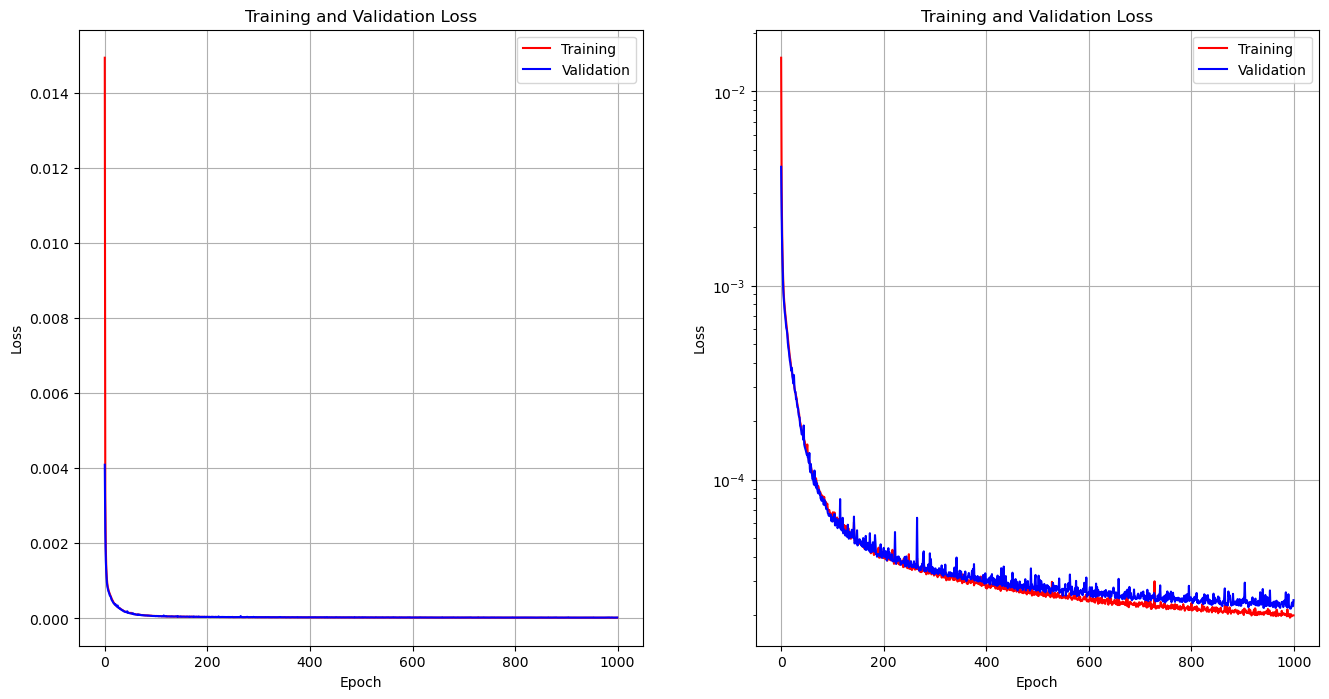

In [14]:
# train and validate model
varmion.training_validation(verbose = True)


result_dict['best_epoch'] = varmion.best_epoch # index of the epoch with lowest validation loss, we save the weights relative to this epoch
with open(save_dir + "/result_dict", "wb") as handle:
    pickle.dump(result_dict, handle)
    
# store model state dictionary
torch.save(varmion.model.state_dict(), save_dir + '/model_weights_best.pth')

# plot and save losses
varmion.plot_losses(save_dir= save_dir)

## Testing

Relative error on the test dataset
Mean: 2.86 %
std:  0.73 %



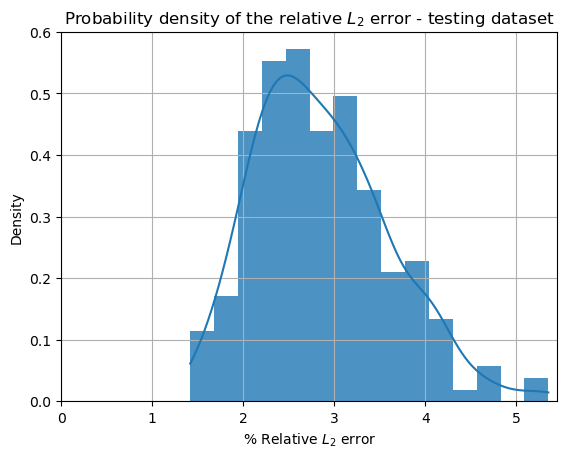

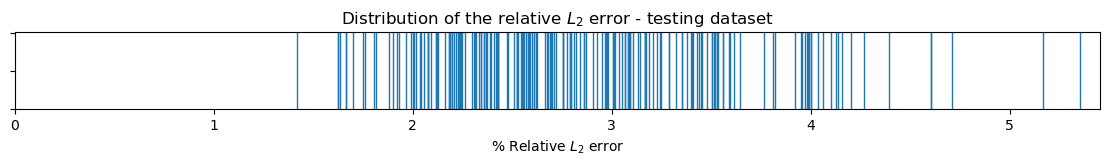

In [15]:
# compute and then plot and save the relative L^2-error on the testing dataset, 
varmion.testing(save_dir = save_dir)

# store error data
torch.save(varmion.test_error_best, save_dir + "/test_error_best.pt")
torch.save(varmion.test_abs_error_best, save_dir + "/test_abs_error_best.pt")

#  Compare numerical solution with model prediction for a single PDE instance


### Select a specific PDE instance by index

In [16]:
# the index can vary between 0 and num_pdes - 1
# example: use varmion.test_data.indices[0] for an instance in the testing dataset
index = varmion.test_data.indices[0]  

In [17]:
pde_data = torch.utils.data.Subset(dataset, [index])

# path of the directory containing the weights to be used for the prediction
weights_dir = save_dir + '/model_weights_best.pth'

# create a model and send it to device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"{device = }")
model = HeatEquationVarMiONRobin()
model.load_state_dict(torch.load(weights_dir, weights_only = True)) ## put correct path
model.to(device)
# set to eval mode
model.eval()


# create a dataloader
loader = DataLoader(pde_data, batch_size=1)
            
# compute predictions
for j, test_data in enumerate(loader): 
            
    X = [elem.to(device) for elem in test_data[:-1]]
    y = test_data[-1]
            
    with torch.no_grad():  
        pred = model(X)
#endfor
        

device = 'cuda'


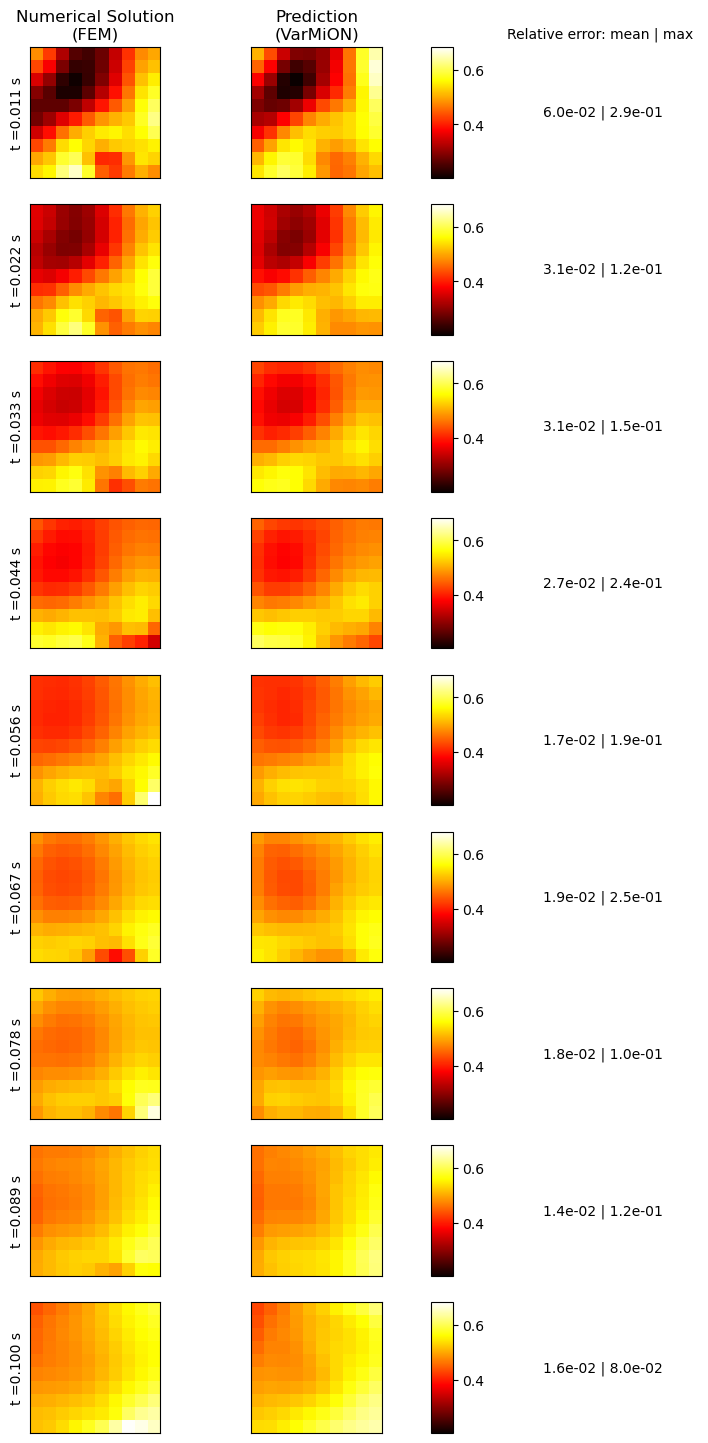

In [18]:
n_times = len(dataset.times)-1  # Number of time steps
array0 = dataset.data['solution'][index,:,:100].numpy().reshape(n_times,10,10) #(n_times, 10, 10)
array1 = pred[0,:,:100].cpu().numpy().reshape(n_times,10,10) #(n_times, 10, 10)


diff = np.abs(array0 - array1).reshape(n_times, 100)
errors_max = np.max(diff, axis=1)
errors_mean = np.mean(diff, axis=1)
err_rel = np.abs((array0 - array1)/array0).reshape(n_times, 100)
rel_errs_max = np.max(err_rel, axis=1)
rel_errs_mean = np.mean(err_rel, axis=1)


# Get global color scale limits
vmin = min(array0.min(), array1.min())
vmax = max(array0.max(), array1.max())

# Create figure
fig = plt.figure(figsize=(6, 2 * n_times))  # Adjust size as needed
gs = gridspec.GridSpec(n_times, 3, width_ratios=[1, 1, 0.1], wspace=0.05)

# Create subplots for each time step
for t in range(n_times):
    ax1 = plt.subplot(gs[t, 0])
    ax2 = plt.subplot(gs[t, 1])
    cbar_ax = plt.subplot(gs[t, 2])

    im1 = ax1.imshow(array0[t], vmin=vmin, vmax=vmax, cmap="hot")
    im2 = ax2.imshow(array1[t], vmin=vmin, vmax=vmax, cmap="hot")
    
    ax1.set_ylabel(f't ={dataset.times[t+1]:.3f} s')

    ax1.set_xticks([])
    ax1.set_yticks([])
    ax2.set_xticks([])
    ax2.set_yticks([])

    if t==0:
        ax1.set_title("Numerical Solution\n(FEM)")
        ax2.set_title("Prediction\n(VarMiON)")
         
    fig.colorbar(im2, cax=cbar_ax)
    
    if t==0:
        fig.text(8, 1.1, "Relative error: mean | max ", fontsize=10, ha="center", va="center", transform=cbar_ax.transAxes)

    rel_error_text = f"{rel_errs_mean[t]:.1e} | {rel_errs_max[t]:.1e}"
    fig.text(8, 0.5, rel_error_text, fontsize=10, ha="center", va="center", transform=cbar_ax.transAxes)

#plt.tight_layout()
plt.show()